In [38]:
import utils.file_utils as fu
import perceptrons.multilayer_perceptron as mlp
import numpy as np
import graphing as g
from tabulate import tabulate
import ex_3.main as main
import metrics as m
import matplotlib.pyplot as plt
import ex_2.main as main2

In [39]:
path_to_config = "ex_3/resources/config.json"
config_file = fu.parse_config(path_to_config)

path_to_data = config_file["path_to_data"]
epoch_limit = int(config_file["epoch_limit"])
execution_count = int(config_file["execution_count"])
momentum = bool(config_file["momentum"])
cross_validation_k = int(config_file["cross_validation"])
hidden_layers = config_file["hidden_layers"]
learn_rate = float(config_file["learn_rate"])
adaptive_learn_rate = bool(config_file["adaptive_learn_rate"])
subproblem = int(config_file["subproblem"])
activation_function = (lambda x: 1/(1+np.exp(-2*x)))
activation_derivative = (lambda x: 2*(1/(1+np.exp(-2*x)))*(1-(1/(1+np.exp(-2*x)))) )


XOR

In [40]:
if subproblem == 1:
    training_set = config_file["training_set"]
    expected_output = config_file["expected_output"]

    error_vs_iteration_path = "ex_3/resources"
    open(error_vs_iteration_path+ "/error_vs_iteration.txt", "w").close()

    p = mlp.MultiLayerPerceptron(learn_rate, hidden_layers, input_dim=len(training_set[0]), output_dim=len(expected_output[0]), update_frequency=0,
    activation_function=activation_function, activation_function_derivative=activation_derivative, update_learn_rate=None, scale_output=False, momentum=momentum)

    w, err = p.train(training_set, expected_output, epoch_limit, callback=(lambda i, error, weights, output: fu.write_error_vs_iteration(error_vs_iteration_path, error, i)))
    g.error_vs_iteration(error_vs_iteration_path, True)
    
    data = []
    for i in range(len(training_set)):
        print("Input: "+str(training_set[i])+" Expected output: " + str(expected_output[i]) + " Output: " + str(p.forward_propagation(training_set[i])))
        data.append([training_set[i], expected_output[i], p.forward_propagation(training_set[i])])

    column_names =["Input", "Expected output", "Prediction"]
    print(tabulate(data, headers=column_names, tablefmt="fancy_grid", showindex="always"))



Paridad

In [41]:
if subproblem == 2:    
    def classify(output_val):
        if output_val[0] > 0.5:
            return 1
        else:
            return 0

    def callback_fun(e, error, weights, output,input_set, output_set, test_input, test_output, i, perceptron):
        results = [classify(perceptron.forward_propagation(item)) for item in input_set]
        test_results = [classify(perceptron.forward_propagation(item)) for item in test_input]
        test_err = perceptron.test_network(test_input, test_output)
        cm_results = m.ConfusionMatrix(results, [item[0] for item in output_set], 0)
        cm_test = m.ConfusionMatrix(test_results, [item[0] for item in test_output], 0)
        if i is not None:
            f = open(path_to_data+"/generalization_error_{}.txt".format(i), "a")
        else:
            f = open(path_to_data+"/generalization_error.txt", "a")
        f.write("{},{},{},{},{},{},{},{},{},{},{}\n".format(e, error, test_err[0], m.accuracy(cm_results), m.accuracy(cm_test), 
        m.precision(cm_results), m.precision(cm_test), m.recall(cm_results), m.recall(cm_test), m.f1_score(cm_results), m.f1_score(cm_test)))
        f.close()

    


In [42]:
if subproblem == 2:
    path_to_data = "ex_3/resources/training"
    training_set, expected_set = main.parse_ej2(path_to_data)
    input_groups, expected_groups = m.cross_validation(training_set,  cross_validation_k, expected_set)
    p = mlp.MultiLayerPerceptron(learn_rate, hidden_layers, len(training_set[0]), len(expected_set[0]), update_frequency=0,
    activation_function=activation_function, activation_function_derivative=activation_derivative, update_learn_rate=None, scale_output=False, momentum=momentum)

    for i, test_group in enumerate(input_groups):
        open(path_to_data+"/generalization_error_{}.txt".format(i), "w").close()
        errors =[]
        t = input_groups[:i] + input_groups[i+1:]
        input_set = [item for sublist in t for item in sublist]
        e = expected_groups[:i] + expected_groups[i+1:]
        output_set = [item for sublist in e for item in sublist]
        w, err = p.train(input_set, output_set, epoch_limit, 
        callback=(lambda e, error, weights, output: callback_fun(e, error, weights, output,input_set, output_set, input_groups[i], expected_groups[i], i, p)))
    

In [43]:
if subproblem == 2:
    j=1
    for i in range(len(input_groups)):
        print(expected_groups[i])
        f = open(path_to_data+"/generalization_error_{}.txt".format(i), "r")
        lines = f.readlines()
        epochs = []
        errors = []
        test_errors = []
        train_accs =[]
        test_accs = []
        train_precs = []
        test_precs = []
        train_recs = []
        test_recs = []
        train_f1s = []
        test_f1s = []
        for line in lines:
            e, error, test_err, train_acc, test_acc, train_prec, test_prec, train_rec, test_rec, train_f1, test_f1  = line.split(",")
            epochs.append(int(e))
            errors.append(float(error))
            test_errors.append(float(test_err))
            train_accs.append(float(train_acc))
            test_accs.append(float(test_acc))
            train_precs.append(float(train_prec))
            test_precs.append(float(test_prec))
            train_recs.append(float(train_rec))
            test_recs.append(float(test_rec))
            train_f1s.append(float(train_f1))
            test_f1s.append(float(test_f1))
        f.close()
        plt.figure(j)
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        # plt.yscale("log")
        plt.plot(epochs, errors, label="Training")
        plt.plot(epochs, test_errors, label="Test")
        plt.legend()
        plt.figure(j+1)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        # plt.yscale("log")
        plt.plot(epochs, train_accs, label="Training")
        plt.plot(epochs, test_accs, label="Test")
        plt.legend()
        plt.figure(j+2)
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        # plt.yscale("log")
        plt.plot(epochs, train_precs, label="Training")
        plt.plot(epochs, test_precs, label="Test")
        plt.legend()
        plt.figure(j+3)
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        # plt.yscale("log")
        plt.plot(epochs, train_recs, label="Training")
        plt.plot(epochs, test_recs, label="Test")
        plt.legend()
        plt.figure(j+4)
        plt.xlabel("Epoch")
        plt.ylabel("F1 score")
        # plt.yscale("log")
        plt.plot(epochs, train_f1s, label="Training")
        plt.plot(epochs, test_f1s, label="Test")
        plt.legend()

        j+=5

ejercicio 3: Valor numérico

In [44]:
def callback_epoch_vs_error(epoch, error, p, test_set, test_expected_output):
    with open(path_to_data+"/epoch_vs_error.txt", "a") as f:
        aux = p.test_network(test_set, test_expected_output)
        f.write("{},{},{}\n".format(epoch, error, np.sum(aux)/len(aux)))
    f.close()


In [45]:
if subproblem == 3:
    path_to_data = "ex_3/resources/training"
    open(path_to_data+"/epoch_vs_error.txt", "w").close()
    training_set, expected_output = main.parse_ej3(path_to_data)
    p = mlp.MultiLayerPerceptron(learn_rate, hidden_layers, len(training_set[0]), len(expected_output[0]), update_frequency=0, activation_function=activation_function, activation_function_derivative=activation_derivative, update_learn_rate=None, scale_output=False, momentum=momentum)
    test_set = main.generate_input_with_noise(path_to_data, 10)
    test_expected_output = [[1,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,0],[0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,1]]
    p.train(training_set, expected_output, epoch_limit, callback=(lambda i, error, weights, output: callback_epoch_vs_error(i, error, p, test_set, test_expected_output)))
    

In [46]:
if subproblem == 3: 
    with open(path_to_data+"/epoch_vs_error.txt", "r") as f:
        lines = f.readlines()
        x ,y ,z = [],[],[]
        for line in lines:
            i,j,k = line.split(",")
            x.append(int(i))
            y.append(float(j))
            z.append(float(k))
        plt.plot(x, y)
        plt.plot(x, z)
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.legend(["Training", "Test"])
        plt.show()
        f.close()

In [47]:
if subproblem == 4:
    path_to_data = "ex_2/resources/training"
    open(path_to_data+"/error_vs_iteration.txt", "w").close()
    training_set, expected_set = fu.parse_training_set_from_file(path_to_data)

    p = mlp.MultiLayerPerceptron(learn_rate, hidden_layers, len(training_set[0]), len(expected_set[0]), update_frequency=0, activation_function=activation_function, activation_function_derivative=activation_derivative, update_learn_rate=None, scale_output=True, momentum=momentum)

    w, err = p.train(training_set, expected_set, epoch_limit, callback=(lambda i, error, weights, output: fu.write_error_vs_iteration(path_to_data, error, i)))

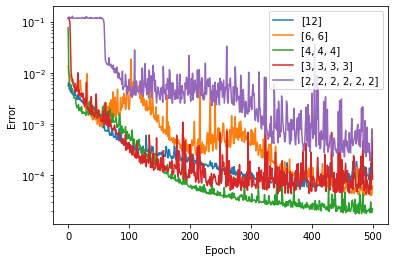

In [53]:
if subproblem == 4:
    labels=["[12]", "[6, 6]", "[4, 4, 4]", "[3, 3, 3, 3]", "[2, 2, 2, 2, 2, 2]"]
    for k in range(1, 6):
        with open(path_to_data+"/error_vs_iteration_{}.txt".format(k), "r") as f:
            lines = f.readlines()
            x ,y = [],[]
            for line in lines:
                i,j = line.split(",")
                x.append(int(i))
                y.append(float(j))
            plt.plot(x, y, label=labels[k-1])
            f.close()
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.legend()